In [ ]:
#Importing library
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import *
from keras.initializers import *
import tensorflow as tf
from keras.optimizer_v2.adam import Adam
from tensorflow.keras.utils import plot_model
import time, random

# Preparing the data

After importing the libraries, we will specify the value for the hyperparameters including the batch size for training, latent dimensionality for the encoding space, and the number of samples to train on.

In [ ]:
#Hyperparameters
batch_size = 64
latent_dim = 256
num_samples = 10000

The below lines of codes will perform the data vectorization where we will read the file containing the English and corresponding French sentences. In the vectorization process, the collection of text documents is converted into feature vectors.

In [ ]:
#Vectorize the data.
input_texts = []
target_texts = []
input_chars = set()
target_chars = set()

In [ ]:
get_file = tf.keras.utils.get_file('fra.txt','https://analyticsindiamag.com/wp-content/uploads/2022/07/fra.txt')

with open(get_file, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_chars:
            input_chars.add(char)
    for char in target_text:
        if char not in target_chars:
            target_chars.add(char)

10215424/10200867 [==============================] - 0s 0us/step


In [ ]:
input_chars = sorted(list(input_chars))
target_chars = sorted(list(target_chars))
num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
#Print size
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59


After getting the data set with all features, we will define the input data for encoder and decoder and the target data for the decoder.

In [ ]:
#Define data for encoder and decoder
input_token_id = dict([(char, i) for i, char in enumerate(input_chars)])
target_token_id = dict([(char, i) for i, char in enumerate(target_chars)])

encoder_in_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')

decoder_in_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_in_data[i, t, input_token_id[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_in_data[i, t, target_token_id[char]] = 1.
        if t > 0:
            decoder_target_data[i, t - 1, target_token_id[char]] = 1.

# **Building and training the Sequential model**

Below lines of codes will define the input sequence for the encoder defined above and process this sequence. After that, an initial state will be set up for the decoder using ‘encoder_states’.

In [ ]:
#Define and process the input sequence
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
#We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

#Using `encoder_states` set up the decoder as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The below line of code will define the final model that will turn `encoder_in_data` & `decoder_in_data` into `decoder_target_data`.

In [ ]:
#Final model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
#Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 93)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        335872      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
#Model data Shape
print("encoder_in_data shape:",encoder_in_data.shape)
print("decoder_in_data shape:",decoder_in_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_in_data shape: (10000, 16, 71)
decoder_in_data shape: (10000, 59, 93)
decoder_target_data shape: (10000, 59, 93)


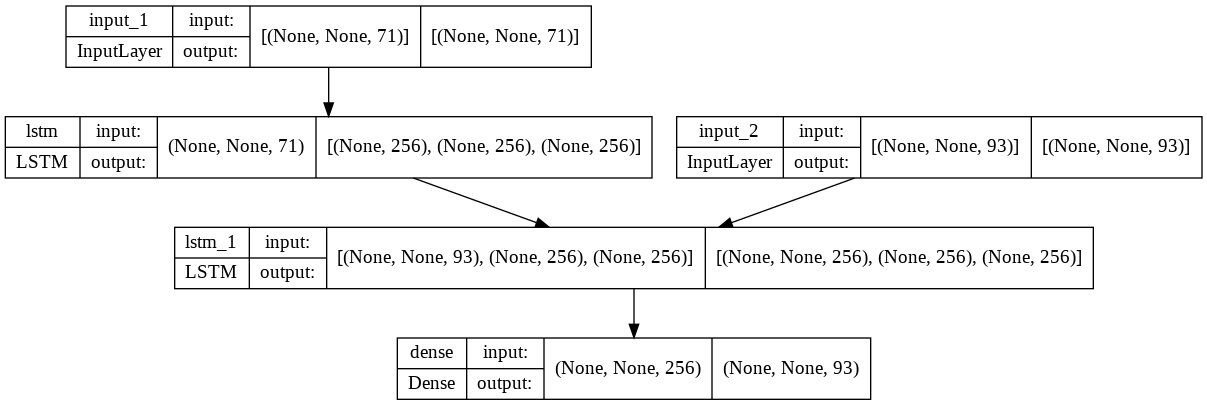

In [ ]:
#Visuaize the model
plot_model(model,show_shapes=True)

In [ ]:
#Compiling and training the model
model.compile(optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')
model.fit([encoder_in_data, decoder_in_data], decoder_target_data, batch_size = batch_size, epochs=50, validation_split=0.2)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


125/125 [==============================] - 53s 396ms/step - loss: 0.9604 - val_loss: 1.0725
Epoch 2/50
125/125 [==============================] - 49s 395ms/step - loss: 0.8570 - val_loss: 0.9989
Epoch 3/50
125/125 [==============================] - 48s 385ms/step - loss: 0.7977 - val_loss: 0.9602
Epoch 4/50
125/125 [==============================] - 50s 397ms/step - loss: 0.7579 - val_loss: 0.9126
Epoch 5/50
125/125 [==============================] - 48s 386ms/step - loss: 0.7215 - val_loss: 0.8740
Epoch 6/50
125/125 [==============================] - 49s 394ms/step - loss: 0.6881 - val_loss: 0.8336
Epoch 7/50
125/125 [==============================] - 49s 389ms/step - loss: 0.6657 - val_loss: 0.8093
Epoch 8/50
125/125 [==============================] - 47s 378ms/step - loss: 0.6345 - val_loss: 0.7660
Epoch 9/50
125/125 [==============================] - 47s 380ms/step - loss: 0.5974 - val_loss: 0.7205
Epoch 10/50
125/125 [==============================] - 49s 390ms/step - loss: 0.5369

# **Predicting the sequence**

After successful training, we will define the sample model using the parameters of the trained model to test language translation.

In [ ]:
#Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

The below part of the codes will define the decode sequence for the text that we will pass to the model as the input sequence. This could be understood as the module for translating the input language into the target language. In this part, the input sequence is encoded into the state vectors.

The state vector and the target sequence is passed to the decoder and it produces the prediction for the next character. Using these predictions, the next character is sampled and it is appended to the target sequence. This process is repeated to generate until the end of the sequence.

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_id.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_id.items())

#Define Decode Sequence
def decode_sequence(input_seq):
    #Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    #Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Get the first character of target sequence with the start character.
    target_seq[0, 0, target_token_id['\t']] = 1.

    #Sampling loop for a batch of sequences
    #(to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        #Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        #Exit condition: either hit max length
        #or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        #Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        #Update states
        states_value = [h, c]

    return decoded_sentence


Finally, we will check our model to decode the input sequence into the target sequence, i.e., translate the English sentences into French sentences.

In [ ]:
for seq_index in range(10):
    input_seq = encoder_in_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Va de !

-
Input sentence: Run!
Decoded sentence: Sorte.

-
Input sentence: Run!
Decoded sentence: Sorte.

-
Input sentence: Wow!
Decoded sentence: Quelle partir.

-
Input sentence: Fire!
Decoded sentence: Arrête !

-
Input sentence: Help!
Decoded sentence: Aide-toi.

-
Input sentence: Jump.
Decoded sentence: Sorter.

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

-
Input sentence: Stop!
Decoded sentence: Arrêtez !

